# Deploying pre-trained PyTorch vision models with Amazon SageMaker Neo

Amazon SageMaker Neo is API to compile machine learning models to optimize them for our choice of hardward targets. Currently, Neo supports pre-trained PyTorch models from [TorchVision](https://pytorch.org/docs/stable/torchvision/models.html). General support for other PyTorch models is forthcoming.

In [1]:
%cd /root/dogs_vs_cats_image_classifier/

/root/dogs_vs_cats_image_classifier


In [2]:
import sys
!{sys.executable} -m pip install torch==1.5.1+cpu torchvision==0.6.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cpu/torch-1.5.1%2Bcpu-cp36-cp36m-linux_x86_64.whl (127.3 MB)
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.6.1%2Bcpu-cp36-cp36m-linux_x86_64.whl (5.7 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0


## Import ResNet18 from TorchVision

We'll import [ResNet18](https://arxiv.org/abs/1512.03385) model from TorchVision and create a model artifact `model.tar.gz`:

In [3]:
import torch
from torchvision import models
import tarfile

resnet18 = models.resnet18(pretrained=True)
input_shape = [1,3,224,224]
trace = torch.jit.trace(resnet18.float().eval(), torch.zeros(input_shape).float())
trace.save('model.pth')

with tarfile.open('model.tar.gz', 'w:gz') as f:
    f.add('model.pth')

## Invoke Neo Compilation API

We then forward the model artifact to Neo Compilation API:

In [4]:
import boto3
import sagemaker
import time
from sagemaker.utils import name_from_base

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()

compilation_job_name = name_from_base('TorchVision-ResNet18-Neo')

model_key = '{}/model/model.tar.gz'.format(compilation_job_name)
model_path = 's3://{}/{}'.format(bucket, model_key)
boto3.resource('s3').Bucket(bucket).upload_file('model.tar.gz', model_key)

sm_client = boto3.client('sagemaker')
data_shape = '{"input0":[1,3,224,224]}'
target_device = 'ml_c5'
framework = 'PYTORCH'
framework_version = '1.2.0'
compiled_model_path = 's3://{}/{}/output'.format(bucket, compilation_job_name)

In [5]:
response = sm_client.create_compilation_job(
    CompilationJobName=compilation_job_name,
    RoleArn=role,
    InputConfig={
        'S3Uri': model_path,
        'DataInputConfig': data_shape,
        'Framework': framework
    },
    OutputConfig={
        'S3OutputLocation': compiled_model_path,
        'TargetDevice': target_device
    },
    StoppingCondition={
        'MaxRuntimeInSeconds': 300
    }
)
print(response)

# Poll every 30 sec
while True:
    response = sm_client.describe_compilation_job(CompilationJobName=compilation_job_name)
    if response['CompilationJobStatus'] == 'COMPLETED':
        break
    elif response['CompilationJobStatus'] == 'FAILED':
        raise RuntimeError('Compilation failed')
    print('Compiling ...')
    time.sleep(30)
print('Done!')

# Extract compiled model artifact
compiled_model_path = response['ModelArtifacts']['S3ModelArtifacts']

{'CompilationJobArn': 'arn:aws:sagemaker:us-east-1:448878779811:compilation-job/TorchVision-ResNet18-Neo-2020-07-12-18-08-30-576', 'ResponseMetadata': {'RequestId': 'b7f10200-ee3b-4919-9be5-ffcdeb86da82', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'b7f10200-ee3b-4919-9be5-ffcdeb86da82', 'content-type': 'application/x-amz-json-1.1', 'content-length': '129', 'date': 'Sun, 12 Jul 2020 18:08:54 GMT'}, 'RetryAttempts': 0}}
Compiling ...
Compiling ...
Done!


## Create prediction endpoint

To create a prediction endpoint, we first specify two additional functions, to be used with Neo Deep Learning Runtime:

* `neo_preprocess(payload, content_type)`: Function that takes in the payload and Content-Type of each incoming request and returns a NumPy array. Here, the payload is byte-encoded NumPy array, so the function simply decodes the bytes to obtain the NumPy array.
* `neo_postprocess(result)`: Function that takes the prediction results produced by Deep Learining Runtime and returns the response body

In [6]:
!pygmentize resnet18.py

def neo_preprocess(payload, content_type):
    import PIL.Image   # Training container doesn't have this package
    import logging
    import numpy as np
    import io

    logging.info('Invoking user-defined pre-processing function')

    if content_type != 'application/x-image':
        raise RuntimeError('Content type must be application/x-image')

    f = io.BytesIO(payload)
    # Load image and convert to RGB space
    image = PIL.Image.open(f).convert('RGB')
    # Resize
    image = np.asarray(image.resize((224, 224)))

    # Normalize
    mean_vec = np.array([0.485, 0.456, 0.406])
    stddev_vec = np.array([0.229, 0.224, 0.225])
    image = (image/255- mean_vec)/stddev_vec

    # Transpose
    if len(image.shape) == 2:  # for greyscale image
        image = np.expand_dims(image, axis=2)
    
    image = np.rollaxis(image, axis=2, start=0)[np.newaxis, :]
    
    return image

def neo_postprocess(result):
    import logging
    import numpy as np
    import json

    logging.inf

Upload the Python script containing the two functions to S3:

In [7]:
source_key = '{}/source/sourcedir.tar.gz'.format(compilation_job_name)
source_path = 's3://{}/{}'.format(bucket, source_key)

with tarfile.open('sourcedir.tar.gz', 'w:gz') as f:
    f.add('resnet18.py')

boto3.resource('s3').Bucket(bucket).upload_file('sourcedir.tar.gz', source_key)

We then create a SageMaker model record:

In [11]:
from sagemaker.model import NEO_IMAGE_ACCOUNT
from sagemaker.fw_utils import create_image_uri

model_name = name_from_base('TorchVision-ResNet18-Neo')

image_uri = create_image_uri(region, 'neo-' + framework.lower(), target_device.replace('_', '.'),
                             framework_version, py_version='py3', account=NEO_IMAGE_ACCOUNT[region])

response = sm_client.create_model(
    ModelName=model_name,
    PrimaryContainer={
        'Image': image_uri,
        'ModelDataUrl': compiled_model_path,
        'Environment': { 'SAGEMAKER_SUBMIT_DIRECTORY': source_path }
    },
    ExecutionRoleArn=role
)
print(response)

{'ModelArn': 'arn:aws:sagemaker:us-east-1:448878779811:model/torchvision-resnet18-neo-2020-07-12-18-14-01-872', 'ResponseMetadata': {'RequestId': '2b303930-30db-4f3c-8313-91cfe2b5726e', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '2b303930-30db-4f3c-8313-91cfe2b5726e', 'content-type': 'application/x-amz-json-1.1', 'content-length': '110', 'date': 'Sun, 12 Jul 2020 18:14:01 GMT'}, 'RetryAttempts': 0}}


Then we create an Endpoint Configuration:

In [12]:
config_name = model_name

response = sm_client.create_endpoint_config(
    EndpointConfigName=config_name,
    ProductionVariants=[
        {
            'VariantName': 'default-variant-name',
            'ModelName': model_name,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.c5.xlarge',
            'InitialVariantWeight': 1.0
        },
    ],
)
print(response)

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:448878779811:endpoint-config/torchvision-resnet18-neo-2020-07-12-18-14-01-872', 'ResponseMetadata': {'RequestId': 'dfc2822a-281f-4908-b5bd-4bff4a715360', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'dfc2822a-281f-4908-b5bd-4bff4a715360', 'content-type': 'application/x-amz-json-1.1', 'content-length': '129', 'date': 'Sun, 12 Jul 2020 18:14:06 GMT'}, 'RetryAttempts': 0}}


Finally, we create an Endpoint:

In [13]:
endpoint_name = model_name + '-Endpoint'

response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=config_name,
)
print(response)

print('Creating endpoint ...')
waiter = sm_client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

response = sm_client.describe_endpoint(EndpointName=endpoint_name)
print(response)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:448878779811:endpoint/torchvision-resnet18-neo-2020-07-12-18-14-01-872-endpoint', 'ResponseMetadata': {'RequestId': '51e93ad1-b73b-4dd1-9bce-0bcc5019f9db', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '51e93ad1-b73b-4dd1-9bce-0bcc5019f9db', 'content-type': 'application/x-amz-json-1.1', 'content-length': '125', 'date': 'Sun, 12 Jul 2020 18:14:19 GMT'}, 'RetryAttempts': 0}}
Creating endpoint ...
{'EndpointName': 'TorchVision-ResNet18-Neo-2020-07-12-18-14-01-872-Endpoint', 'EndpointArn': 'arn:aws:sagemaker:us-east-1:448878779811:endpoint/torchvision-resnet18-neo-2020-07-12-18-14-01-872-endpoint', 'EndpointConfigName': 'TorchVision-ResNet18-Neo-2020-07-12-18-14-01-872', 'ProductionVariants': [{'VariantName': 'default-variant-name', 'DeployedImages': [{'SpecifiedImage': '785573368785.dkr.ecr.us-east-1.amazonaws.com/sagemaker-neo-pytorch:1.2.0-cpu-py3', 'ResolvedImage': '785573368785.dkr.ecr.us-east-1.amazonaws.com/sagemaker-neo-pyto

## Send requests

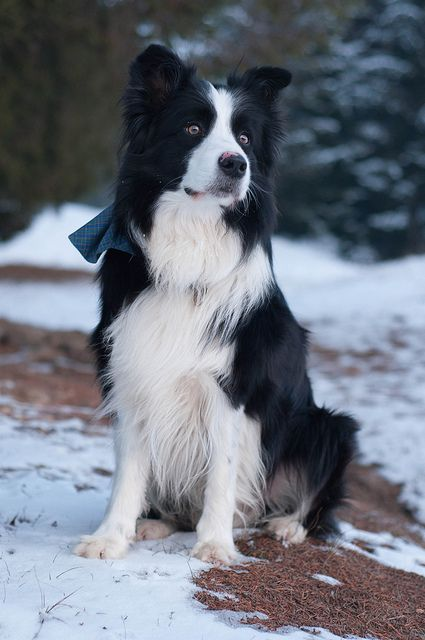

In [19]:
file_name = 'test_images/dog.jpg'
# test image
from IPython.display import Image
Image(file_name)

In [20]:
import json
import numpy as np

sm_runtime = boto3.Session().client('sagemaker-runtime')

with open(file_name, 'rb') as f:
    payload = f.read()

response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                      ContentType='application/x-image',
                                      Body=payload)
print(response)

{'ResponseMetadata': {'RequestId': 'b6ecba24-4ca6-4db6-b513-f618a5870dd4', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'b6ecba24-4ca6-4db6-b513-f618a5870dd4', 'x-amzn-invoked-production-variant': 'default-variant-name', 'date': 'Sun, 12 Jul 2020 18:32:09 GMT', 'content-type': 'application/json', 'content-length': '23351'}, 'RetryAttempts': 0}, 'ContentType': 'application/json', 'InvokedProductionVariant': 'default-variant-name', 'Body': <botocore.response.StreamingBody object at 0x7f951e5289b0>}


In [21]:
result = json.loads(response['Body'].read().decode())
print('Most likely class: {}'.format(np.argmax(result)))

Most likely class: 232


In [22]:
# Load names for ImageNet classes
object_categories = {}
with open("imagenet1000_clsidx_to_labels.txt", "r") as f:
    for line in f:
        key, val = line.strip().split(':')
        object_categories[key] = val
print("Result: label - " + object_categories[str(np.argmax(result))]+ " probability - " + str(np.amax(result)))

Result: label -  'Border collie', probability - 0.866693377494812


## Delete the Endpoint
Having an endpoint running will incur some costs. Therefore as a clean-up job, we should delete the endpoint.

In [23]:
sess.delete_endpoint(endpoint_name)